In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import GPR
import Options
import BlackScholes as BS
import ImpliedVolatility as IV
import Probability_Utils as Prob

TICKER = 'SPY'

Collect SPY Option Data & Build Call Option Dictionary

In [2]:
ExpiryDates = yf.Ticker(TICKER).options
print(ExpiryDates)
DateN = np.arange(len(ExpiryDates))
current_price = yf.Ticker(TICKER).history(period='1d')['Close'][0]
CallOptions = pd.DataFrame()
for i in DateN:
    print(f"{i}: {ExpiryDates[DateN[i]]}")
    options = yf.Ticker(TICKER).option_chain(ExpiryDates[DateN[i]])
    Calls = options.calls
    Puts = options.puts
    CallOptions = pd.concat([CallOptions, pd.DataFrame({
        'Strike': Calls['strike'],
        'bid': Calls['bid'],
        'ask': Calls['ask'],
        'Price': np.where(
            (Calls['bid'] == 0) | (Calls['ask'] == 0),
            Calls['lastPrice'],
            (Calls['bid'] + Calls['ask']) / 2
        ),
        'YF_IV': Calls['impliedVolatility'],
        'Type': 'C',
        'Expiry': pd.to_datetime(ExpiryDates[DateN[i]]),
        'T_market_years': (Options.trading_days_between(pd.Timestamp.today(), pd.to_datetime(ExpiryDates[DateN[i]])) / 252),
        'Spot': current_price,
        'Rate': 0.04,
        'ForwardPrice': current_price * np.exp(0.04 * (Options.trading_days_between(pd.Timestamp.today(), pd.to_datetime(ExpiryDates[DateN[i]])) / 252))
    })])

K = Calls['strike']
k = np.log(Calls['strike'] / current_price)


('2025-10-08', '2025-10-09', '2025-10-10', '2025-10-13', '2025-10-14', '2025-10-15', '2025-10-16', '2025-10-17', '2025-10-24', '2025-10-31', '2025-11-07', '2025-11-14', '2025-11-21', '2025-11-28', '2025-12-19', '2025-12-31', '2026-01-16', '2026-01-30', '2026-02-20', '2026-02-27', '2026-03-20', '2026-03-31', '2026-06-18', '2026-06-30', '2026-09-18', '2026-09-30', '2026-12-18', '2027-01-15', '2027-12-17', '2028-01-21')
0: 2025-10-08


C:\Users\adamd\AppData\Local\Temp\ipykernel_22848\179470872.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_price = yf.Ticker(TICKER).history(period='1d')['Close'][0]


1: 2025-10-09
2: 2025-10-10
3: 2025-10-13
4: 2025-10-14
5: 2025-10-15
6: 2025-10-16
7: 2025-10-17
8: 2025-10-24
9: 2025-10-31
10: 2025-11-07
11: 2025-11-14
12: 2025-11-21
13: 2025-11-28
14: 2025-12-19
15: 2025-12-31
16: 2026-01-16
17: 2026-01-30
18: 2026-02-20
19: 2026-02-27
20: 2026-03-20
21: 2026-03-31
22: 2026-06-18
23: 2026-06-30
24: 2026-09-18
25: 2026-09-30
26: 2026-12-18
27: 2027-01-15
28: 2027-12-17
29: 2028-01-21


Visualize IV Slices and Term Structure

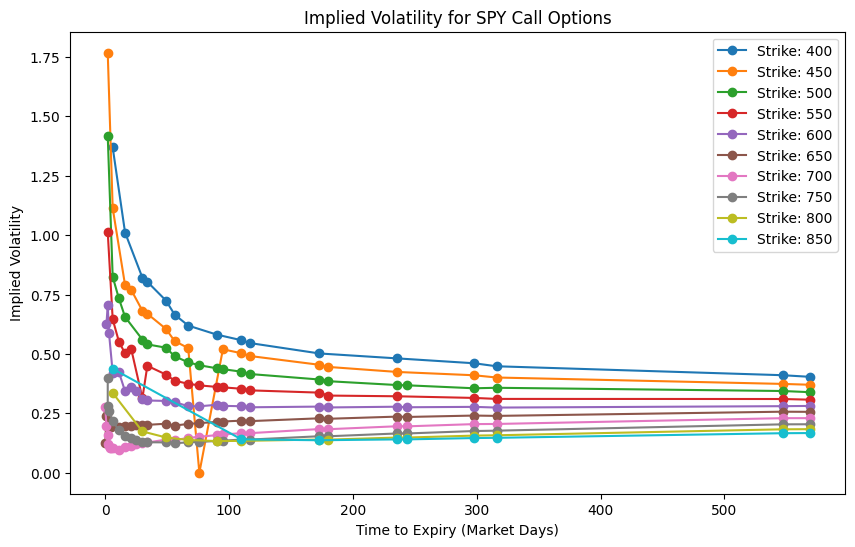

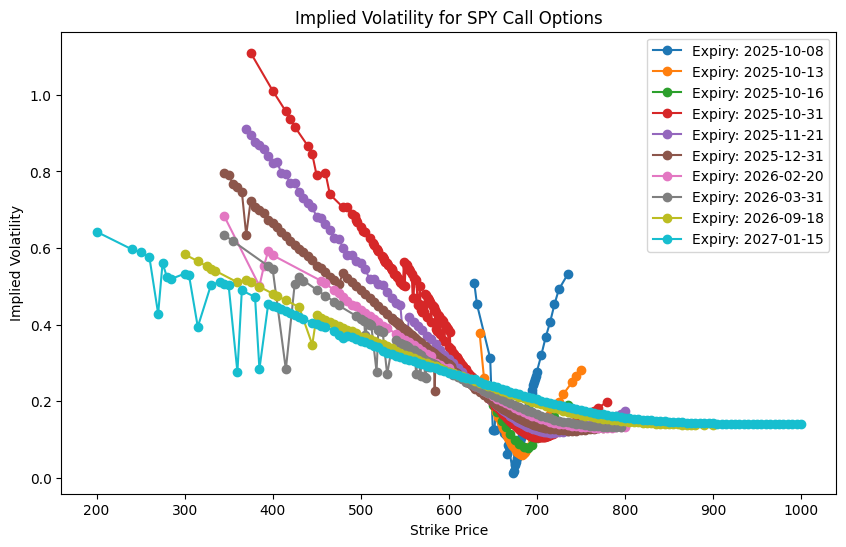

In [ ]:
# plot IV across time for different strikes
plt.figure(figsize=(10, 6))
Strike_to_plot = np.arange(400, 900, 50)
for i in range(len(Strike_to_plot)):
    plt.plot(   CallOptions[CallOptions['Strike'] == Strike_to_plot[i]]['T_market_years'] * 252,
                CallOptions[CallOptions['Strike'] == Strike_to_plot[i]]['YF_IV'],
                marker='o', linestyle='-', label=f'Strike: {Strike_to_plot[i]}')
plt.title(f'Implied Volatility for {TICKER} Call Options')
plt.xlabel('Time to Expiry (Market Days)')
plt.ylabel('Implied Volatility')
plt.legend()
plt.show()

# plot IV across strikes for different expiry
plt.figure(figsize=(10, 6))
for i in range(len(ExpiryDates)):
    if i % 3 == 0:
        Date_mask = CallOptions['Expiry'] == pd.to_datetime(ExpiryDates[i])
        IV_mask = CallOptions[Date_mask]['YF_IV'] > 1e-3
        plt.plot(   CallOptions[Date_mask][IV_mask]['Strike'],
                    CallOptions[Date_mask][IV_mask]['YF_IV'],
                    marker='o', linestyle='-', label=f'Expiry: {ExpiryDates[i]}')
plt.title(f'Implied Volatility for {TICKER} Call Options')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.legend()
plt.show()



Calculate Implied Volatility for all entires

In [5]:
CallOptions['Implied Volatility'] = IV.BS_Implied_Volatility_MultiExpiry(CallOptions)


K = np.arange(400, 900, 1)

# fit to SVI curve
result, svi_curve, svi_k, w = IV.fit_IV_slice(CallOptions)
plt.plot(K, svi_k(K), color='green', label='SVI k function')
plt.plot(CallOptions['Strike'], w/np.max(w)/10, color='purple', label='Weights function')
plt.plot(CallOptions['Strike'], svi_curve, color='red', label='Fitted SVI Curve')
plt.legend()
plt.show()



(1/30): Calculating IV for Expiry: 2025-10-08 00:00:00


C:\Projects\Quant\Quant\ImpliedVolatility.py:25: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Projects\Quant\Quant\ImpliedVolatility.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


(2/30): Calculating IV for Expiry: 2025-10-09 00:00:00
(3/30): Calculating IV for Expiry: 2025-10-10 00:00:00
(4/30): Calculating IV for Expiry: 2025-10-13 00:00:00
(5/30): Calculating IV for Expiry: 2025-10-14 00:00:00
(6/30): Calculating IV for Expiry: 2025-10-15 00:00:00
(7/30): Calculating IV for Expiry: 2025-10-16 00:00:00
(8/30): Calculating IV for Expiry: 2025-10-17 00:00:00
(9/30): Calculating IV for Expiry: 2025-10-24 00:00:00
(10/30): Calculating IV for Expiry: 2025-10-31 00:00:00
(11/30): Calculating IV for Expiry: 2025-11-07 00:00:00
(12/30): Calculating IV for Expiry: 2025-11-14 00:00:00
(13/30): Calculating IV for Expiry: 2025-11-21 00:00:00
(14/30): Calculating IV for Expiry: 2025-11-28 00:00:00
(15/30): Calculating IV for Expiry: 2025-12-19 00:00:00
(16/30): Calculating IV for Expiry: 2025-12-31 00:00:00
(17/30): Calculating IV for Expiry: 2026-01-16 00:00:00
(18/30): Calculating IV for Expiry: 2026-01-30 00:00:00
(19/30): Calculating IV for Expiry: 2026-02-20 00:00:00


ValueError: Initial guess is outside of provided bounds

In [ ]:
P, P_k = IV.Distribution_from_IV(CallOptions, svi_curve, svi_k)

Area, mu, stddev, skew, kurt = Prob.moments(K, P_k(K))
print(f"Area: {Area}, Mean: {mu}, StdDev: {stddev}, Skew: {skew}, Kurtosis: {kurt}")

plt.figure(figsize=(10, 6))
plt.plot(K, P_k(K), color='green', label='Risk-Neutral PDF Larger Domain')
plt.plot(CallOptions['Strike'], P, color='blue', label='Risk-Neutral PDF')
plt.axvline(x=current_price, color='black', linestyle='--', label='Current Price')
plt.axvline(x=ForwardPrice, color='orange', linestyle='--', label='Forward Price')
plt.axhline(y=0, color='black', linestyle='-')
plt.title(f'Risk-Neutral PDF from Implied Volatility (Expiry: {ExpiryDates[DateN]})')
plt.xlabel('Strike Price')
plt.ylabel('Density')
plt.legend()
plt.show()

In [ ]:
BS_Call_Prices = BS.BS_Option_Price(CallOptions, svi_curve)

plt.figure(figsize=(10, 6))
plt.scatter(CallOptions['Strike'], CallOptions['Price'], color='blue', label='Market Prices')
plt.plot(CallOptions['Strike'], BS_Call_Prices, color='red', label='Black-Scholes Prices')
plt.axvline(x=current_price, color='black', linestyle='--', label='Current Price')
plt.axvline(x=ForwardPrice, color='orange', linestyle='--', label='Forward Price')
plt.title(f'Call Option Prices for {TICKER} (Expiry: {ExpiryDates[DateN]})')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(CallOptions['Strike'], CallOptions['ask']-CallOptions['bid'], color='blue', label='B-A Spread')
plt.title(f'Bid-Ask Spread for {TICKER} Call Options (Expiry: {ExpiryDates[DateN]})')
plt.xlabel('Strike Price')
plt.ylabel('Spread')
plt.legend()
plt.show()

In [ ]:

# print(Calls)

# Find Characteristic Function of Underlying Asset Return Distribution
# Phi = -u^2 * int(exp(iuK) * C(K) dK) 
import torch
K = torch.tensor(K.values, dtype=torch.float32)
C = torch.tensor(Calls['lastPrice'].values, dtype=torch.float32)

# interpolate to evenly spaced grid
NPoints = 2**10
K = torch.linspace(650, 700, NPoints)
from scipy.interpolate import interp1d
C = interp1d(Calls['strike'], Calls['lastPrice'], bounds_error=False, fill_value="extrapolate")(K)
C = torch.tensor(C, dtype=torch.float32)
dK = K[1] - K[0]

du = 2 * np.pi / (NPoints * dK)
u = torch.fft.fftshift(torch.fft.fftfreq(NPoints, d=dK)) * 2 * torch.pi
C_fft = torch.fft.fftshift(torch.fft.fft(torch.fft.ifftshift(C))) * dK
C_kk_rec = torch.fft.fftshift(torch.fft.ifft(torch.fft.ifftshift(- u**2 * C_fft))) * NPoints * du / (2 * np.pi)
C_kk_rec = C_kk_rec.real

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.plot(K, C, label='Call Prices C(K)')
plt.title('Data Call Prices C(K)')
plt.xlabel('K')
plt.ylabel('C(K)')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(u, torch.real(C_fft), label='Re(φ(u))')
plt.plot(u, torch.imag(C_fft), label='Im(φ(u))')
plt.title('Fourier Transform φ(u)')
plt.xlabel('u')
plt.ylabel('φ(u)')
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(K, C_kk_rec, label='Reconstructed d2C(K)/dK2', linestyle='--')
plt.title('Reconstructed Function d2C(K)/dK2')
plt.xlabel('K')
plt.ylabel('d2C(K)/dK2')
plt.ylim(-10, 10)
plt.legend()
plt.tight_layout()
plt.show()


mu, COV, mu_xx = GPR.fit_option_price(Calls['strike'], Calls['lastPrice'], current_price)
f, h, w = Options.fit_option_price_hermite(Calls['strike'], Calls['lastPrice'], current_price, N = 7, w0=np.array([1, 0, 1, 0, 1, 0, 1]))


In [ ]:

plt.figure(figsize=(10, 6))
plt.scatter(K, Calls['lastPrice'], color='blue', label='Call Prices')
plt.plot(K, mu, color='red', label='GPR Mean')
plt.plot(K, f, color='green', label='Options Fit')
plt.axvline(x=current_price, color='orange', linestyle='--', label='Current Price')
plt.legend()
plt.title(f'GPR Fit to {TICKER} Call Option Prices (Expiry: {ExpiryDates[3]})')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.show()

plt.figure(figsize=(10, 6))
# plt.plot(K, mu_xx, color='orange', label='d2mu/dK2')
# mu_xx = np.maximum(mu_xx, 0) / np.abs(np.trapezoid(Calls['strike'].values, np.maximum(mu_xx, 0)))  # Ensure non-negativity & Normalize
# plt.plot(K, mu_xx, color='green', label='Non-negative d2mu/dK2')
plt.plot(K, h**2, color='purple', label='d2F/dK2')
plt.plot(K, h**2 / np.abs(np.trapezoid(K, h**2)), color='red', label='Normalized d2F/dK2')
plt.axvline(x=current_price, color='orange', linestyle='--', label='Current Price')
plt.plot(K, h, color='blue', label='h(K)')
plt.title(f'Second Derivative of Option Price Fit (Expiry: {ExpiryDates[3]})')
plt.xlabel('Strike Price')
plt.ylabel('Second Derivative')
plt.legend()
plt.show()

